<a href="https://colab.research.google.com/github/toka-amer/Handwritten-Signature-Verification/blob/main/Stage1BOV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/CV_2023_SC_Dataset.zip'

Archive:  /content/CV_2023_SC_Dataset.zip
   creating: personA/Test/
  inflating: personA/Test/personA_10.png  
  inflating: personA/Test/personA_13.png  
  inflating: personA/Test/personA_2.png  
  inflating: personA/Test/personA_20.png  
  inflating: personA/Test/personA_27.png  
  inflating: personA/Test/personA_29.png  
  inflating: personA/Test/personA_30.png  
  inflating: personA/Test/personA_42.png  
  inflating: personA/Test/personA_SigVerificationTestLabels.csv  
   creating: personA/Train/
  inflating: personA/Train/personA_1.png  
  inflating: personA/Train/personA_11.png  
  inflating: personA/Train/personA_12.png  
  inflating: personA/Train/personA_14.png  
  inflating: personA/Train/personA_15.png  
  inflating: personA/Train/personA_16.png  
  inflating: personA/Train/personA_17.png  
  inflating: personA/Train/personA_18.png  
  inflating: personA/Train/personA_19.png  
  inflating: personA/Train/personA_21.png  
  inflating: personA/Train/personA_22.png  
  inflating

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import os
from joblib import Parallel, delayed
import joblib

class ImageHelpers:
    def __init__(self):
        self.sift_object = cv2.xfeatures2d.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]


class BOVHelpers:
    def __init__(self, n_clusters=20):
        self.n_clusters = n_clusters
        self.kmeans_obj = KMeans(n_clusters=n_clusters)
        self.kmeans_ret = None
        self.descriptor_vstack = None
        self.mega_histogram = None
        self.clf = SVC()

    def cluster(self):
        """
		cluster using KMeans algorithm, 

		""" 
        km = self.kmeans_obj.fit(self.descriptor_vstack)
        joblib.dump(km,'Kmeans.pkl')
        self.kmeans_ret = km.predict(self.descriptor_vstack)
           
    def developVocabulary(self, n_images, descriptor_list):

        """
		Each cluster denotes a particular visual word 
		Every image can be represeted as a combination of multiple 
		visual words. The best method is to generate a sparse histogram
		that contains the frequency of occurence of each visual word 

		Thus the vocabulary comprises of a set of histograms of encompassing
		all descriptions for all images

		"""

        self.mega_histogram = np.array([np.zeros(self.n_clusters) for i in range(n_images)])
        old_count = 0
        for i in range(n_images):
            l = len(descriptor_list[i])
            for j in range(l):
                idx = self.kmeans_ret[old_count + j]
                self.mega_histogram[i][idx] += 1
            old_count += l
        print("Vocabulary Histogram Generated")

    def standardize(self, std=None):
        """
		
		standardize is required to normalize the distribution
		wrt sample size and features. If not normalized, the classifier may become
		biased due to steep variances.

		"""
        if std is None:
            self.scale = StandardScaler().fit(self.mega_histogram)
            joblib.dump(self.scale,'Scaler.pkl')
            self.mega_histogram = self.scale.transform(self.mega_histogram)
        else:
            print("STD not none. External STD supplied")
            self.mega_histogram = std.transform(self.mega_histogram)

    def formatND(self, l):
        """
		restructures list into vstack array of shape
		M samples x N features for sklearn

		"""
        vStack = np.array(l[0])
        for remaining in l[1:]:
            vStack = np.vstack((vStack, remaining))
        self.descriptor_vstack = vStack.copy()
        return

    def train(self, train_labels):
        """
		uses sklearn.svm.SVC classifier (SVM) 


		"""
        print("Training SVM")
        print(self.clf)
        print("Train labels", train_labels)
        self.clf.fit(self.mega_histogram, train_labels)
        joblib.dump(self.clf, 'SVM.pkl')
        print("Training completed")

    def predict(self, iplist):
        predictions = self.clf.predict(iplist)
        return predictions

    def plotHist(self, vocabulary=None):
        print("Plotting histogram")
        if vocabulary is None:
            vocabulary = self.mega_histogram

        x_scalar = np.arange(self.n_clusters)
        y_scalar = np.array([abs(np.sum(vocabulary[:, h], dtype=np.int32)) for h in range(self.n_clusters)])

        print(y_scalar)

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()


class FileHelpers:

    def __init__(self):
        pass

    def getFiles(self, path,isTrain):
        """
		- returns  a dictionary of all files 
		having key => value as  objectname => image path

		- returns total number of files.

		"""
        imlist = {}
        count = 0
        for each in os.listdir(path):
            print(" #### Reading image category ", each, " ##### ")
            imlist[each] = []
            for imagefile in os.listdir(path + '/' + each):
                if isTrain and imagefile == "Train":                
                  for image in os.listdir(path + '/' + each + '/' + imagefile):
                    print("Reading file ", image)
                    pathType = image.split('.')[-1]
                    if pathType != 'csv':
                      im = cv2.imread(path + '/' + each + '/' + imagefile + '/' + image, 0)
                      imlist[each].append(im)
                      count += 1
                elif isTrain == False and imagefile == "Test":
                  for image in os.listdir(path + '/' + each + '/' + imagefile):
                    print("Reading file ", image)
                    pathType = image.split('.')[-1]
                    if pathType != 'csv':
                      im = cv2.imread(path + '/' + each + '/' + imagefile + '/' + image, 0)
                      imlist[each].append(im)
                      count += 1

        return [imlist, count]


 #### Reading image category  personB  ##### 
Reading file  personB_37.png
Reading file  personB_21.png
Reading file  personB_24.png
Reading file  personB_45.png
Reading file  personB_SigVerificationTrainLabels.csv
Reading file  personB_11.png
Reading file  personB_18.png
Reading file  personB_47.png
Reading file  personB_30.png
Reading file  personB_25.png
Reading file  personB_32.png
Reading file  personB_28.png
Reading file  personB_19.png
Reading file  personB_1.png
Reading file  personB_36.png
Reading file  personB_22.png
Reading file  personB_7.png
Reading file  personB_44.png
Reading file  personB_14.png
Reading file  personB_34.png
Reading file  personB_15.png
Reading file  personB_6.png
Reading file  personB_8.png
Reading file  personB_48.png
Reading file  personB_38.png
Reading file  personB_4.png
Reading file  personB_16.png
Reading file  personB_3.png
Reading file  personB_43.png
Reading file  personB_17.png
Reading file  personB_12.png
Reading file  personB_26.png
Reading 

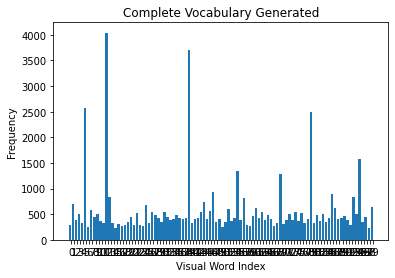

Training SVM
SVC()
Train labels [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4.]
Training completed
 #### Reading image category  personB  ##### 
Reading file  personB_33.png
Reading file  personB_10.png
Reading file  personB_SigVerificationTestLabels.csv
Reading file  personB_2.png
Reading file  personB_27.png
Reading file  personB_42.png
Reading file  personB_29.png
Reading file  personB_13.png
Reading file  personB_20.png
 #### Read

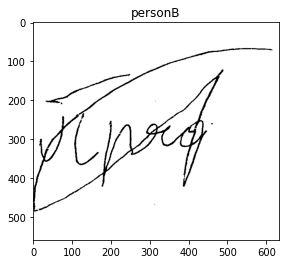

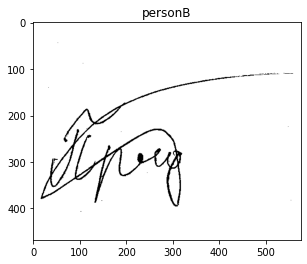

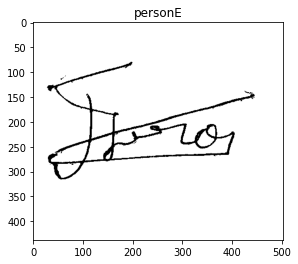

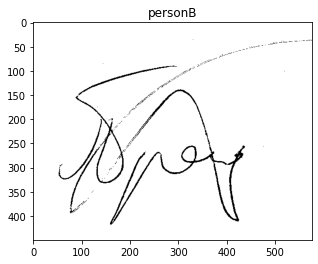

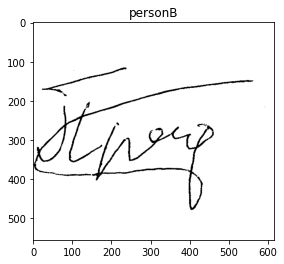

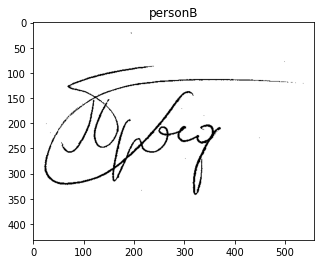

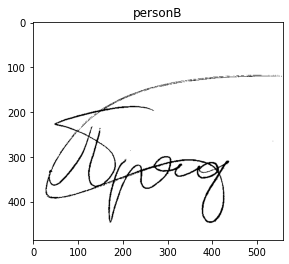

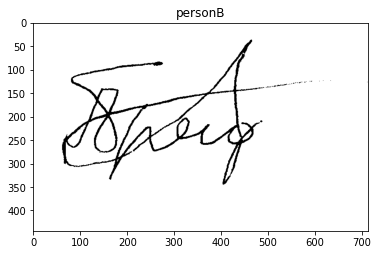

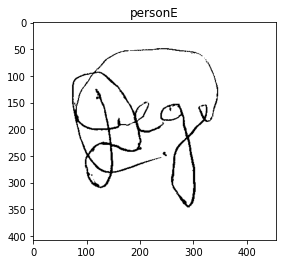

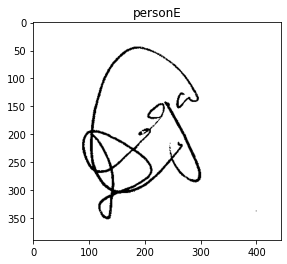

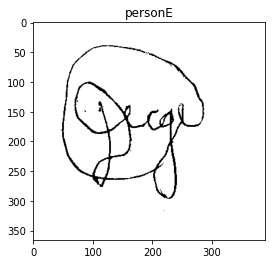

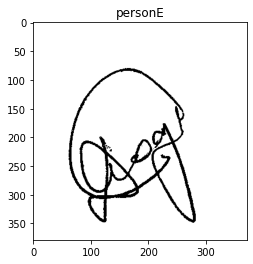

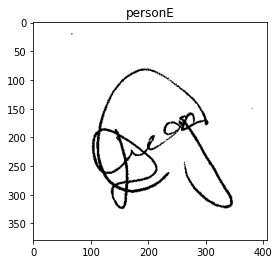

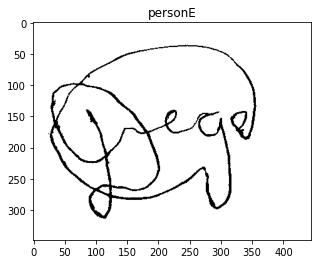

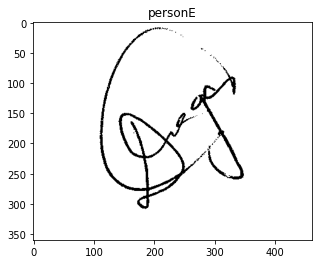

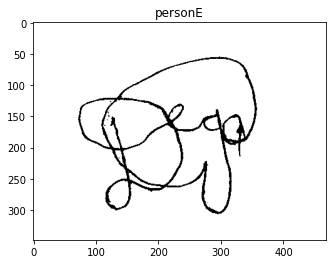

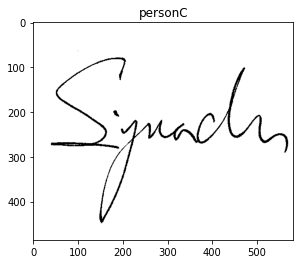

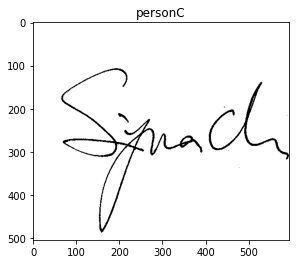

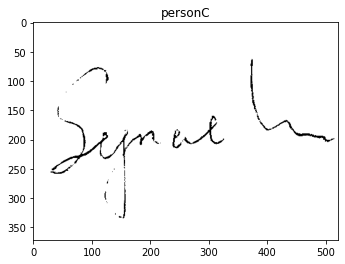

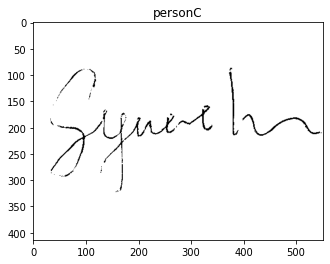

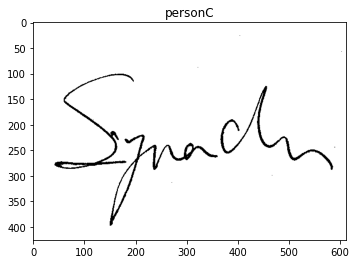

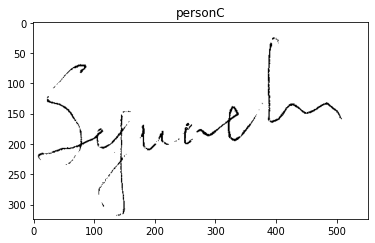

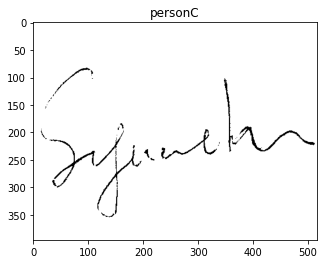

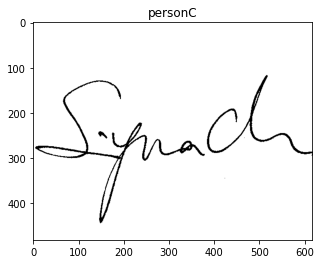

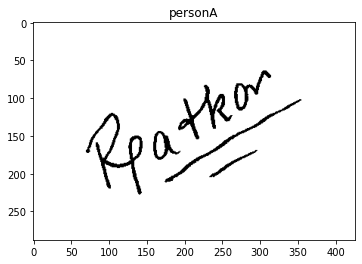

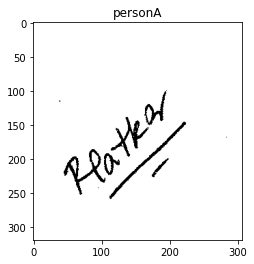

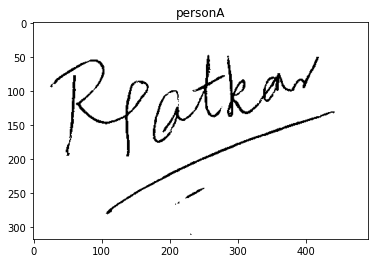

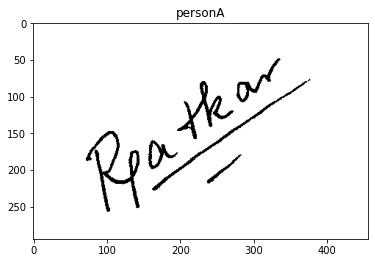

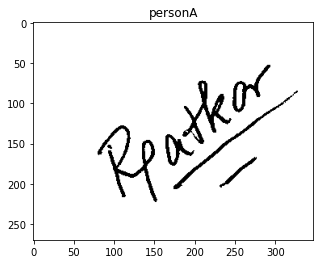

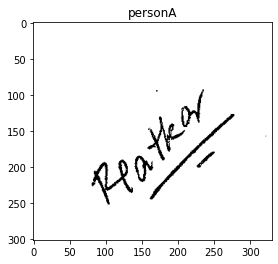

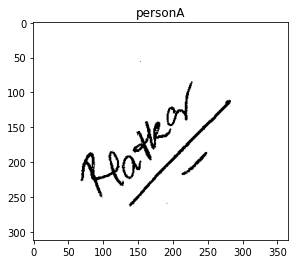

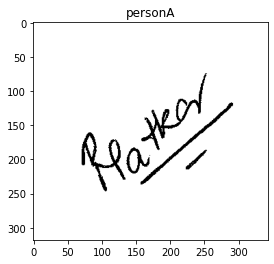

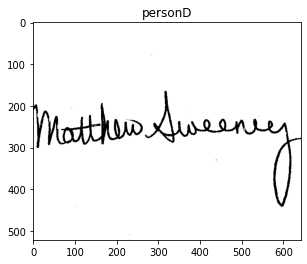

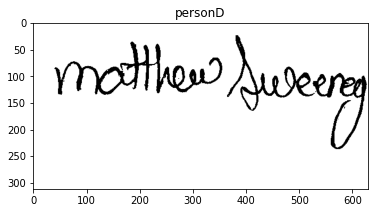

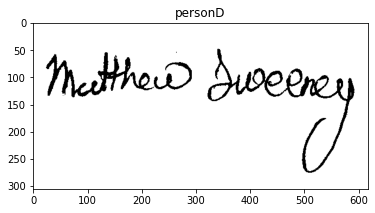

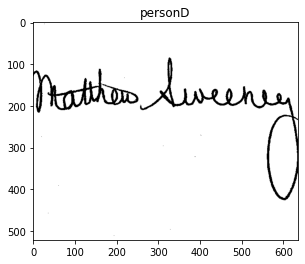

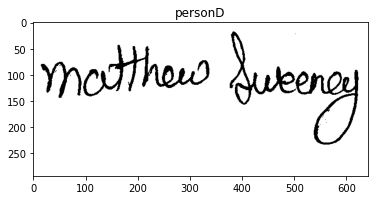

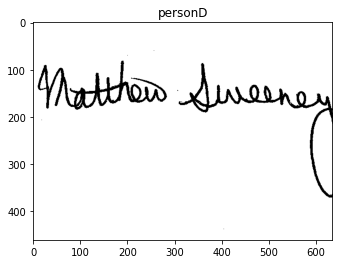

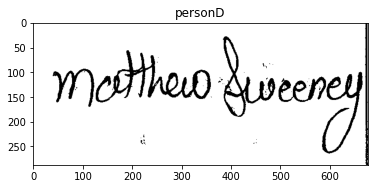

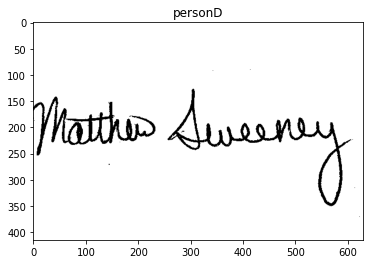

In [ ]:
import cv2
import numpy as np 
from glob import glob
from matplotlib import pyplot as plt 


class BOV:
    def __init__(self, no_clusters):
        self.no_clusters = no_clusters
        self.train_path = None
        self.test_path = None
        self.im_helper = ImageHelpers()
        self.bov_helper = BOVHelpers(no_clusters)
        self.file_helper = FileHelpers()
        self.images = None
        self.trainImageCount = 0
        self.train_labels = np.array([])
        self.name_dict = {}
        self.descriptor_list = []




    def trainModel(self):
        """
        This method contains the entire module 
        required for training the bag of visual words model

        Use of helper functions will be extensive.

        """

        # read file. prepare file lists.
        self.images, self.trainImageCount = self.file_helper.getFiles(self.train_path,True)
        # extract SIFT Features from each image
        label_count = 0 
        for word, imlist in self.images.items():
            self.name_dict[str(label_count)] = word
            print ("Computing Features for ", word)
            for im in imlist:
                # cv2.imshow("im", im)
                # cv2.waitKey()
                self.train_labels = np.append(self.train_labels, label_count)
                kp, des = self.im_helper.features(im)
                self.descriptor_list.append(des)

            label_count += 1


        # perform clustering
        self.bov_helper.formatND(self.descriptor_list)
        self.bov_helper.cluster()
        self.bov_helper.developVocabulary(n_images = self.trainImageCount, descriptor_list=self.descriptor_list)

        # show vocabulary trained
        self.bov_helper.plotHist()

        self.bov_helper.standardize()
        self.bov_helper.train(self.train_labels)


    def recognize(self,test_img, test_image_path=None):

        """ 
        This method recognizes a single image 
        It can be utilized individually as well.


        """

        kp, des = self.im_helper.features(test_img)
        # print kp
        print (des.shape)

        # generate vocab for test image
        vocab = np.array( [[ 0 for i in range(self.no_clusters)]])
        vocab = np.array(vocab, 'float32')
        # locate nearest clusters for each of 
        # the visual word (feature) present in the image
        
        # test_ret =<> return of kmeans nearest clusters for N features
        test_ret = self.bov_helper.kmeans_obj.predict(des)
        # print test_ret

        # print vocab
        for each in test_ret:
            vocab[0][each] += 1

        #print (vocab)

        # Scale the features
        vocab = self.bov_helper.scale.transform(vocab)
        # predict the class of the image
        lb = self.bov_helper.clf.predict(vocab)
        # print "Image belongs to class : ", self.name_dict[str(int(lb[0]))]
        return lb



    def testModel(self):
        """ 
        This method is to test the trained classifier

        read all images from testing path 
        use BOVHelpers.predict() function to obtain classes of each image

        """
        correctClassifications = 0
        self.testImages, self.testImageCount = self.file_helper.getFiles(self.test_path,False)

        predictions = []

        for word, imlist in self.testImages.items():
            print ("processing " ,word)
            for im in imlist:
                # print imlist[0].shape, imlist[1].shape
                print (im.shape)
                cl = self.recognize(im)
                print (cl)
                predictions.append({
                    'image':im,
                    'class':cl,
                    'object_name':self.name_dict[str(int(cl[0]))]
                    })

                if(self.name_dict[str(int(cl[0]))]==word):
                    correctClassifications = correctClassifications + 1

        print("Test Accuracy = " + str((correctClassifications/self.testImageCount) * 100))
        #print (predictions)
        for each in predictions:
            # cv2.imshow(each['object_name'], each['image'])
            # cv2.waitKey()
            # cv2.destroyWindow(each['object_name'])
            # 
            plt.imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
            plt.title(each['object_name'])
            plt.show()


    def print_vars(self):
        pass



bov = BOV(no_clusters=100)

# set training paths
bov.train_path = "/content/Data"
# set testing paths
bov.test_path = "/content/Data" 
# train the model
bov.trainModel()
# test model
bov.testModel()
